#  1. Importações e dados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_theme()

In [2]:
import pandas as pd

# Carregar a base original
df = pd.read_csv('/home/fause/ML-Transportes/PBIC/Etapa3/acidentes_pbic_2020_2025_Final.csv', encoding="utf-8")

df_acidentes = df.drop_duplicates(subset=["id", "pesid"]).copy()

df.tail()


/tmp/ipykernel_80827/493917375.py:4: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/fause/ML-Transportes/PBIC/Etapa3/acidentes_pbic_2020_2025_Final.csv', encoding="utf-8")


,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,mes,dia_mes,hora,gravidade_numerica,total_vitimas,Marca_Principal,Modelo_Grupo,Nome_Modelo,Fabricante,Modelo
1678321,705809.0,1571785.0,2025-05-01,quinta-feira,19:50:00,SE,101.0,"98,6",SAO CRISTOVAO,Sim,...,5,1,19,0,0.0,Não Informado,Não Informado,NO,Não Informado,NO
1678322,705809.0,1571786.0,2025-05-01,quinta-feira,19:50:00,SE,101.0,"98,6",SAO CRISTOVAO,Sim,...,5,1,19,3,1.0,HONDA,CG 125 FAN ES,CG,HONDA,CG
1678323,705809.0,1571785.0,2025-05-01,quinta-feira,19:50:00,SE,101.0,"98,6",SAO CRISTOVAO,Sim,...,5,1,19,0,0.0,Não Informado,Não Informado,NO,Não Informado,NO
1678324,705883.0,1571987.0,2025-06-22,domingo,12:30:00,MG,354.0,764,ITAMONTE,Sim,...,6,22,12,1,1.0,HONDA,CB 650R,CB,HONDA,CB
1678325,705883.0,1571987.0,2025-06-22,domingo,12:30:00,MG,354.0,764,ITAMONTE,Sim,...,6,22,12,1,1.0,HONDA,CB 650R,CB,HONDA,CB


#informações 

In [3]:
# Contar o número de valores únicas na coluna 'marca'
numero_Fabricante_unicas = df_acidentes['Fabricante'].nunique()
numero_Modelo_unicas = df_acidentes['Modelo'].nunique()

print(f"O número de marcas de veículos diferentes é: {numero_Fabricante_unicas}")
print(f"O número de modelos diferentes é: {numero_Modelo_unicas}")


O número de marcas de veículos diferentes é: 230
O número de modelos diferentes é: 1500


In [4]:
# Contar a frequência de cada marca e mostrar as 10 mais frequentes
marcas_mais_frequentes = df_acidentes['Fabricante'].value_counts().head(10)

print("As 10 Fabricante de veículos que mais aparecem são:")
print(marcas_mais_frequentes)

As 10 Fabricante de veículos que mais aparecem são:
Fabricante
HONDA            123184
VOLKSWAGEN        77962
FIAT              65259
CHEVROLET         61500
Não Informado     38899
MERCEDES-BENZ     34127
FORD              32023
YAMAHA            23799
SCANIA            22871
VOLVO             21933
Name: count, dtype: int64


# Veiculos x Acidentes

In [5]:
df_veiculos = df_acidentes[(df_acidentes['ano_fabricacao_veiculo'] >= 1990) & (df_acidentes['ano_fabricacao_veiculo'] <= 2025)].copy()


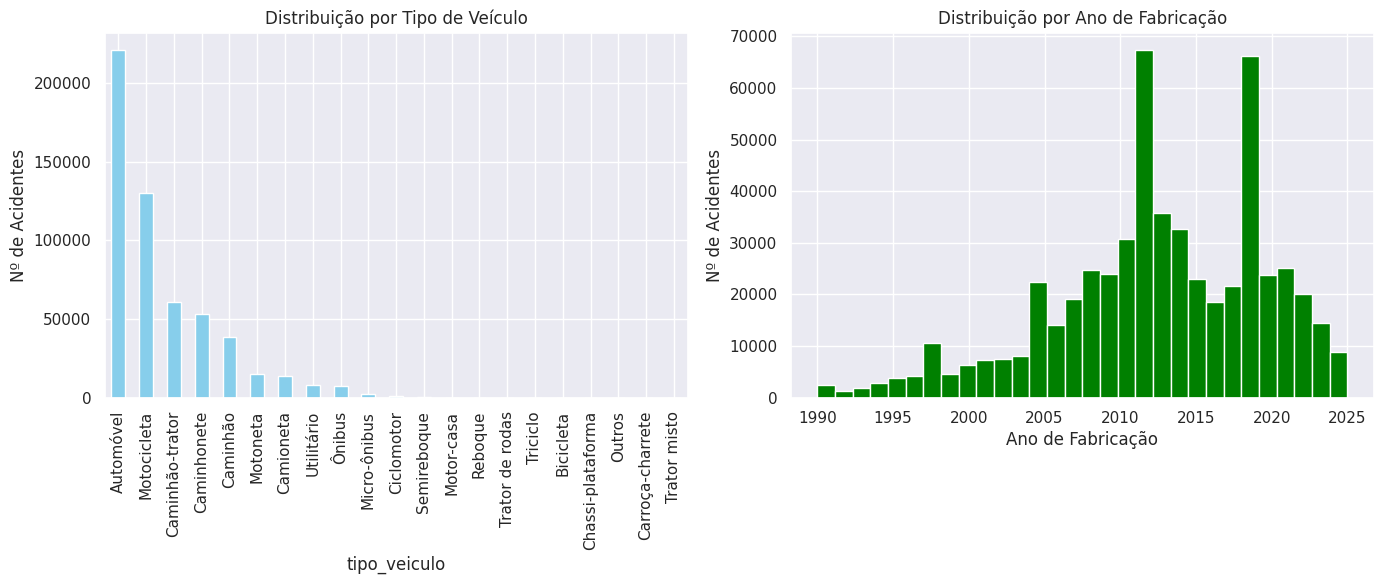

In [6]:

if {'tipo_veiculo', 'ano_fabricacao_veiculo'}.issubset(df_veiculos.columns):
    fig, axes = plt.subplots(1, 2, figsize=(14,6))

    # Distribuição por tipo de veículo
    df_veiculos['tipo_veiculo'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title("Distribuição por Tipo de Veículo")
    axes[0].set_ylabel("Nº de Acidentes")

    # Distribuição por ano de fabricação
    df_veiculos['ano_fabricacao_veiculo'].dropna().astype(int).hist(ax=axes[1], bins=30, color='green')
    axes[1].set_title("Distribuição por Ano de Fabricação")
    axes[1].set_xlabel("Ano de Fabricação")
    axes[1].set_ylabel("Nº de Acidentes")

    plt.tight_layout()
    plt.show()


# Nº de Acidentes por Ano de Fabricação (Top 15 Marcas)

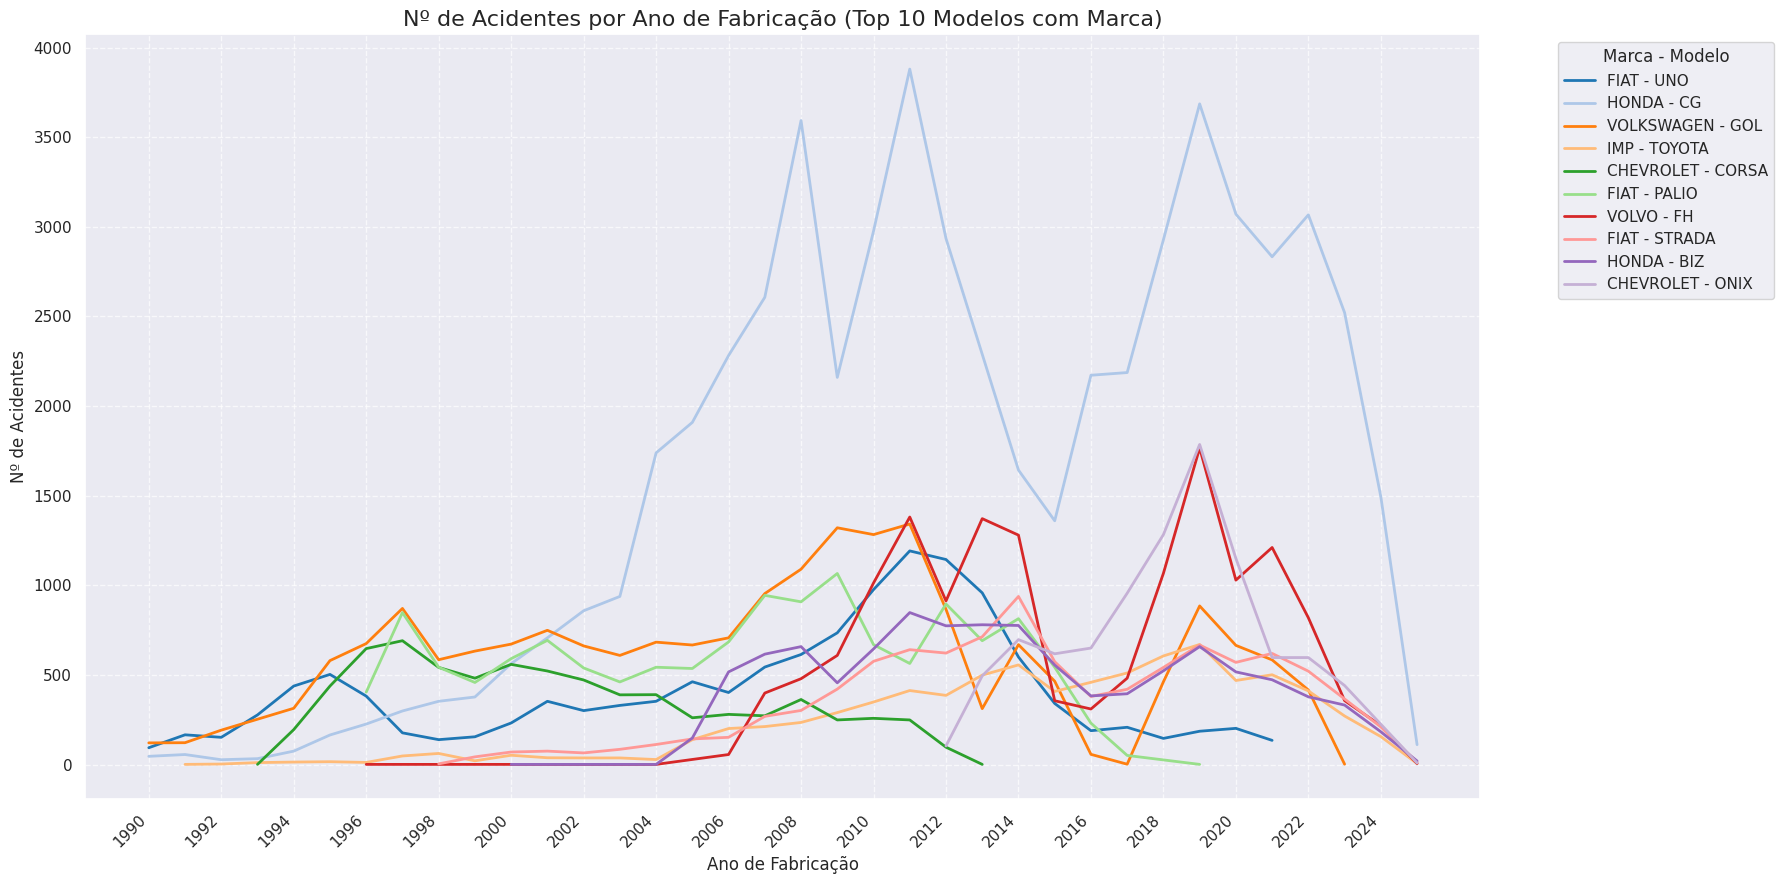

In [7]:
# Pressupondo que df_veiculos já está carregado e contém 'Modelo', 'Fabricante' e 'ano_fabricacao_veiculo'

# 1. Identificar os top 10 modelos
top_10_modelos = df_veiculos['Modelo'].value_counts().nlargest(10).index.tolist()

# 2. Filtrar o DataFrame, limpar e agrupar
df_top_10 = df_veiculos[df_veiculos['Modelo'].isin(top_10_modelos)].copy()

# Limpeza e conversão ano
df_top_10['ano_fabricacao_veiculo'] = pd.to_numeric(
    df_top_10['ano_fabricacao_veiculo'], errors='coerce', downcast='integer'
)
df_top_10.dropna(subset=['ano_fabricacao_veiculo'], inplace=True)
df_top_10['ano_fabricacao_veiculo'] = df_top_10['ano_fabricacao_veiculo'].astype(int)

# 3. Mapear cada Modelo → Fabricante
marca_modelo_map = df_top_10.groupby('Modelo')['Fabricante'].first().to_dict()

# Criar o rótulo correto: Marca - Modelo
df_top_10['Marca_Modelo_Label'] = df_top_10.apply(
    lambda row: f"{marca_modelo_map[row['Modelo']]} - {row['Modelo']}", axis=1
)

# 4. Agrupamento: acidentes por ano de fabricação + modelo
df_contagem = df_top_10.groupby(
    ['ano_fabricacao_veiculo', 'Marca_Modelo_Label']
).size().reset_index(name='Nº de Acidentes')

# 5. Plot
plt.figure(figsize=(18, 9))

sns.lineplot(
    data=df_contagem,
    x='ano_fabricacao_veiculo',
    y='Nº de Acidentes',
    hue='Marca_Modelo_Label',
    palette='tab20',
    linewidth=2
)

plt.title('Nº de Acidentes por Ano de Fabricação (Top 10 Modelos com Marca)', fontsize=16)
plt.xlabel('Ano de Fabricação', fontsize=12)
plt.ylabel('Nº de Acidentes', fontsize=12)

anos_unicos = df_contagem['ano_fabricacao_veiculo'].unique()
plt.xticks(rotation=45, ha='right', ticks=anos_unicos[::2])

plt.legend(title='Marca - Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Distribuição (Top 15 Marca - Modelo)

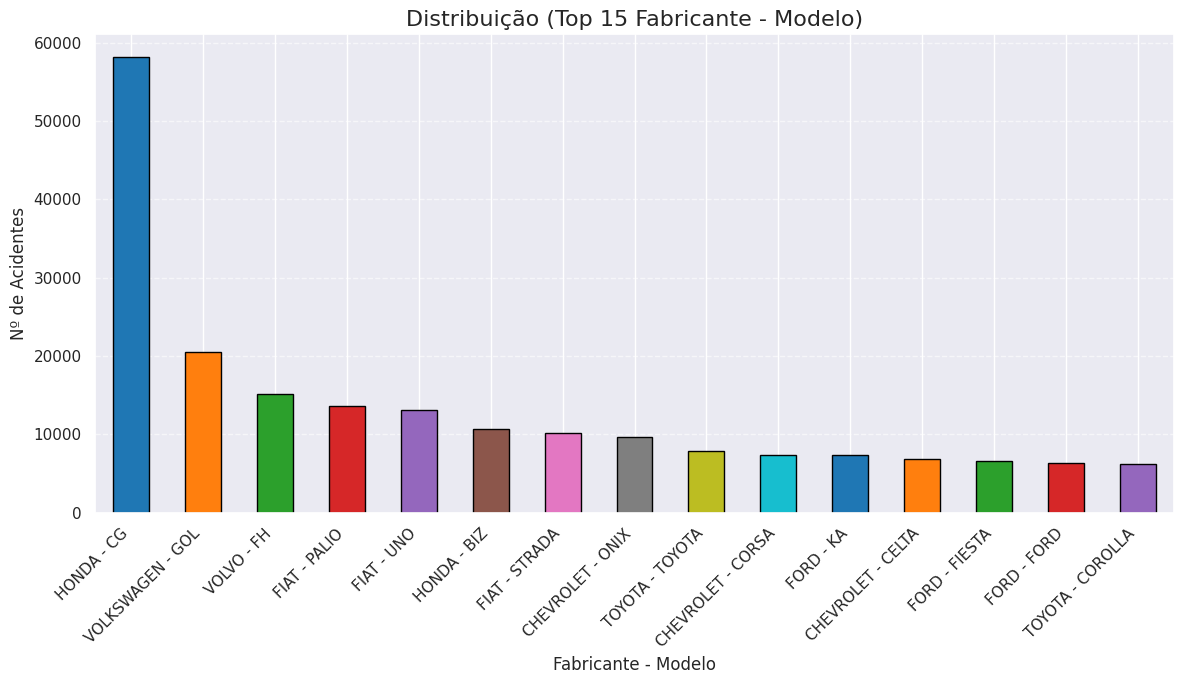

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Remover linhas com CG150
df_veiculos = df_veiculos[~df_veiculos['Modelo'].str.contains("CG150", case=False, na=False)]

# --- Pré-processamento e Criação do Rótulo Combinado ---

top_15_modelos = df_veiculos['Modelo'].value_counts().nlargest(15).index.tolist()
df_top_15 = df_veiculos[df_veiculos['Modelo'].isin(top_15_modelos)].copy()

df_top_15['Marca_Modelo_Label'] = df_top_15.apply(
    lambda row: f"{row['Fabricante']} - {row['Modelo']}", axis=1
)

contagem_marca_modelo = df_top_15['Marca_Modelo_Label'].value_counts().nlargest(15)

# --- Geração do Gráfico Único ---
if {'Modelo', 'Fabricante'}.issubset(df_veiculos.columns):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    contagem_marca_modelo.plot(
        kind='bar',
        ax=ax,
        color=sns.color_palette("tab10", 15),
        edgecolor='black'
    )
    ax.set_title("Distribuição (Top 15 Fabricante - Modelo)", fontsize=16)
    ax.set_ylabel("Nº de Acidentes", fontsize=12)
    ax.set_xlabel("Fabricante - Modelo", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("O DataFrame 'df_veiculos' precisa das colunas 'Modelo' e 'Fabricante'.")


#Top Veículos (Geral) com Mais Acidentes e Tipos de Acidente

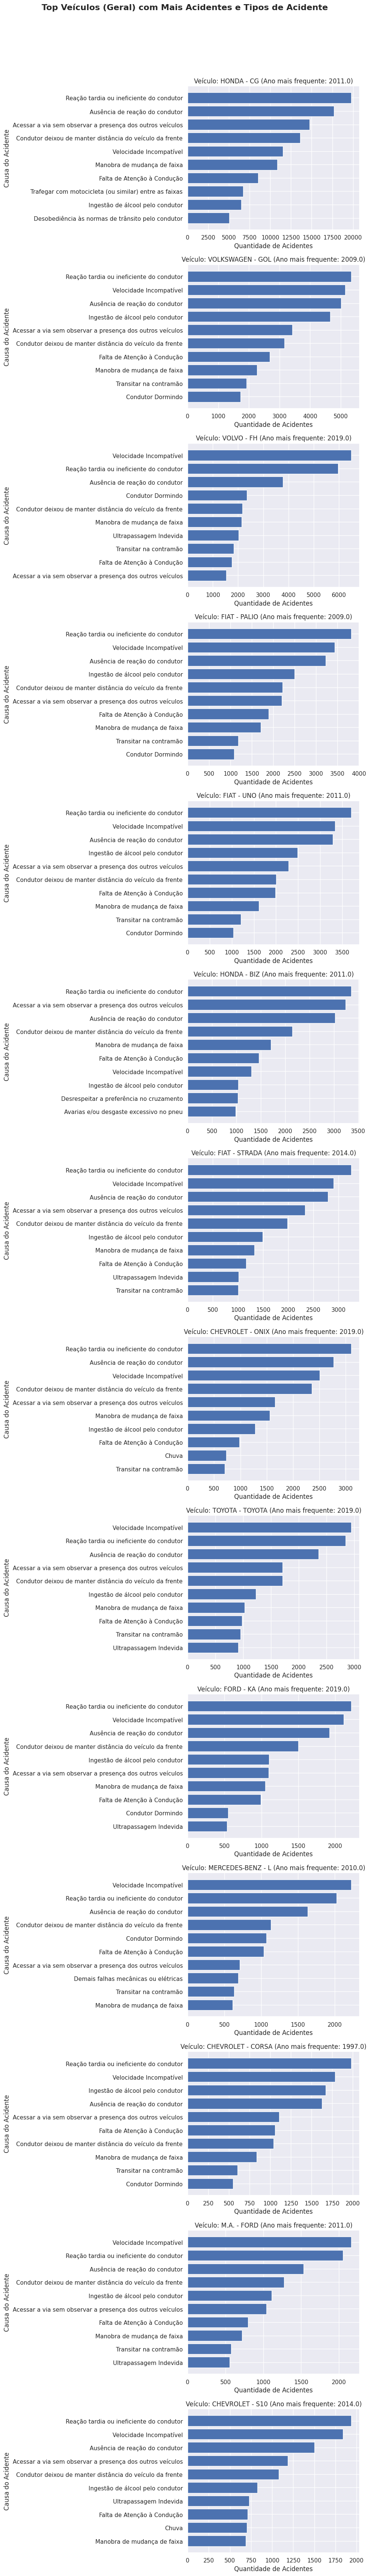

In [9]:
# Definir valores a excluir
valor_excluir_exato = 'NO'
substring_excluir = 'CG150'

# Filtragem geral
df_limpo = df[
    (~df['Modelo'].eq(valor_excluir_exato)) &
    (~df['Modelo'].str.contains(substring_excluir, case=False, na=False))
].copy()

# Mapeamento Modelo -> Fabricante
try:
    marca_map = (
        df_limpo[['Modelo', 'Fabricante']]
        .drop_duplicates()
        .set_index('Modelo')['Fabricante']
        .to_dict()
    )
except KeyError:
    print("Erro: faltam colunas Modelo ou Fabricante.")
    marca_map = {}

# Top 20 modelos com mais acidentes, pegar os 14 primeiros
top_veiculos = (
    df_limpo.groupby('Modelo')['causa_acidente']
    .count()
    .reset_index(name='qtd_acidentes')
    .sort_values('qtd_acidentes', ascending=False)
    .head(14)
)

n_veiculos = len(top_veiculos)

if n_veiculos == 0:
    print("Nenhum veículo para plotar.")
else:
    fig, axes = plt.subplots(n_veiculos, 1, figsize=(10, 5*n_veiculos), sharex=False)
    fig.suptitle("Top Veículos (Geral) com Mais Acidentes e Tipos de Acidente", fontsize=16, fontweight='bold')

    if n_veiculos == 1:
        axes = [axes]

    for ax, veiculo in zip(axes, top_veiculos['Modelo']):

        df_veiculo = df_limpo[df_limpo['Modelo'] == veiculo].copy()

        top_causas = (
            df_veiculo.groupby('causa_acidente')
            .size()
            .reset_index(name='qtd_acidentes')
            .sort_values('qtd_acidentes', ascending=False)
            .head(10)
        )

        # Ano mais frequente
        if not df_veiculo.empty and 'ano_fabricacao_veiculo' in df_veiculo.columns:
            ano_mais_frequente = df_veiculo['ano_fabricacao_veiculo'].mode().iloc[0]
        else:
            ano_mais_frequente = "N/A"

        # Marca principal do modelo
        marca_principal = marca_map.get(veiculo, 'Desconhecida')
        titulo_combinado = f"{marca_principal} - {veiculo}"

        ax.barh(top_causas['causa_acidente'], top_causas['qtd_acidentes'])
        ax.set_title(f"Veículo: {titulo_combinado} (Ano mais frequente: {ano_mais_frequente})")
        ax.set_xlabel("Quantidade de Acidentes")
        ax.set_ylabel("Causa do Acidente")
        ax.invert_yaxis()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Não informado 

/tmp/ipykernel_80827/3935631555.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_80827/3935631555.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


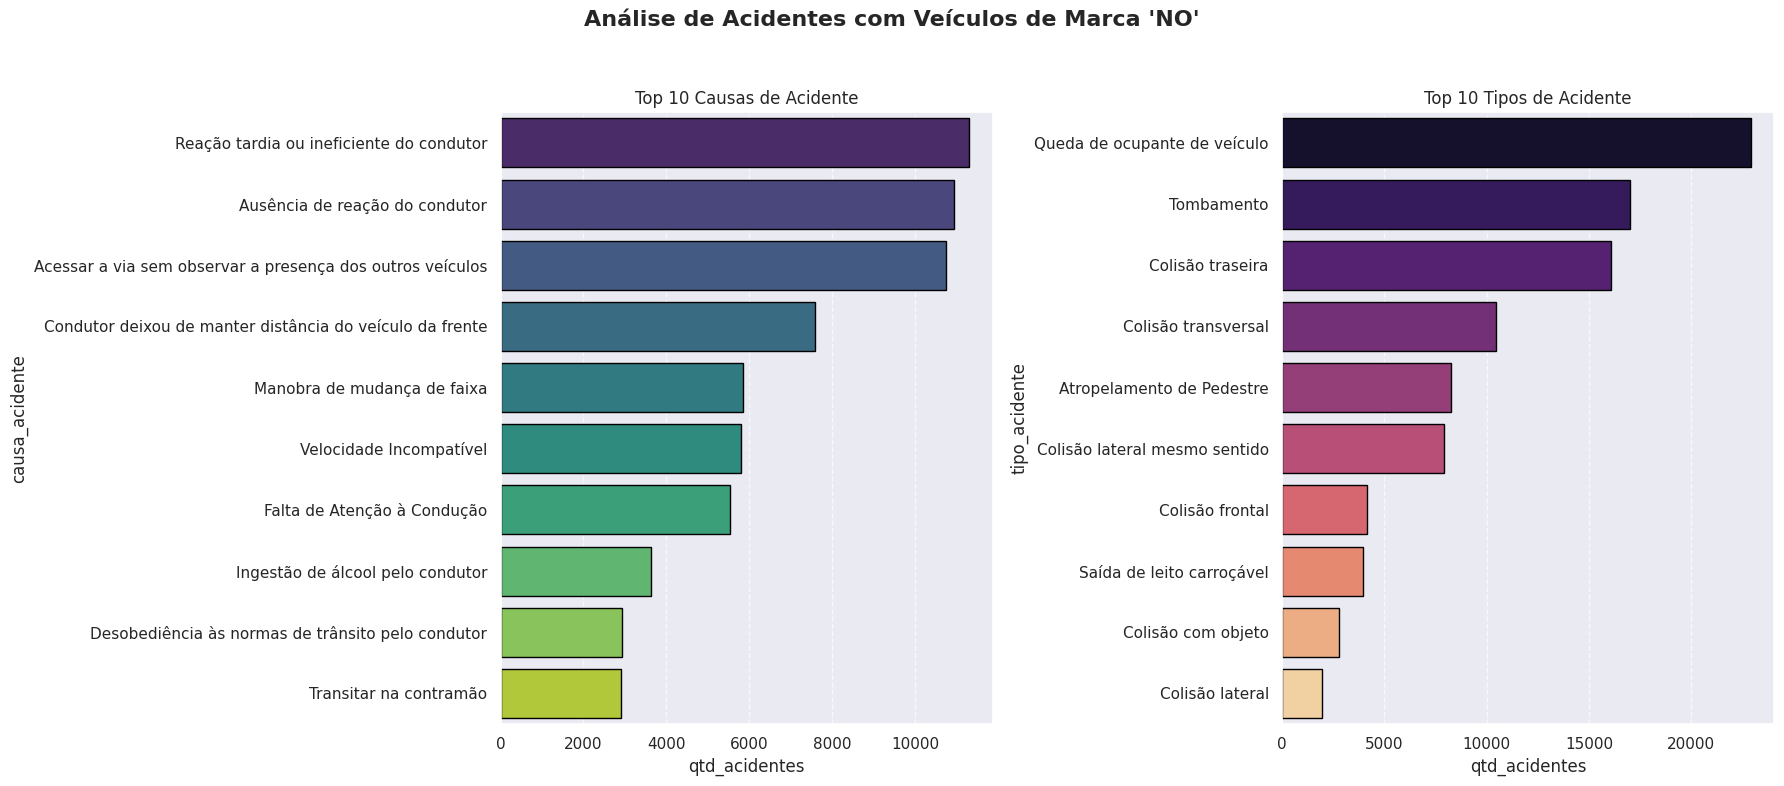

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Verifica colunas obrigatórias
required_cols = ['Modelo', 'causa_acidente', 'tipo_acidente']
missing = [c for c in required_cols if c not in df.columns]

if missing:
    print("Erro: Faltam colunas no DataFrame:", missing)
else:
    # 1. Filtra exclusivamente Modelo = 'NO'
    df_no = df[df['Modelo'].astype(str).str.upper() == 'NO'].copy()

    if df_no.empty:
        print("Nenhum registro com Modelo = 'NO'.")
    else:
        # Tratar NaN como 'Não Informado' (opcional)
        df_no['causa_acidente'] = df_no['causa_acidente'].fillna("Não Informado")
        df_no['tipo_acidente'] = df_no['tipo_acidente'].fillna("Não Informado")

        # Top 10
        top_causas_no = (
            df_no.groupby('causa_acidente')
            .size()
            .reset_index(name='qtd_acidentes')
            .sort_values('qtd_acidentes', ascending=False)
            .head(10)
        )

        top_tipos_no = (
            df_no.groupby('tipo_acidente')
            .size()
            .reset_index(name='qtd_acidentes')
            .sort_values('qtd_acidentes', ascending=False)
            .head(10)
        )

        # Plots
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
        fig.suptitle("Análise de Acidentes com Veículos de Marca 'NO'", fontsize=16, fontweight='bold')

        # Gráfico 1
        sns.barplot(
            data=top_causas_no,
            x='qtd_acidentes',
            y='causa_acidente',
            ax=axes[0],
            palette='viridis',
            edgecolor='black'
        )
        axes[0].set_title("Top 10 Causas de Acidente")
        axes[0].grid(axis='x', linestyle='--', alpha=0.7)

        # Gráfico 2
        sns.barplot(
            data=top_tipos_no,
            x='qtd_acidentes',
            y='tipo_acidente',
            ax=axes[1],
            palette='magma',
            edgecolor='black'
        )
        axes[1].set_title("Top 10 Tipos de Acidente")
        axes[1].grid(axis='x', linestyle='--', alpha=0.7)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
